The goal of this post is to write some code that can generate direct^[**NOT** using a Markov Chain Monte Carlo (MCMC) method.] samples from a Cauchy Markov random field (CMRF) [@Chada2021] [@Markkanen2019] on a 2D regular lattice. A more general [Markov Random Field](https://en.wikipedia.org/wiki/Markov_random_field) (MRF) is just a multivariate probability distribution possessing a special conditional-independence property amongst the components. This property permits the use of efficient numerical methods developed to exploit this property. CMRFs are cousins of the better-known Gaussian Markov Random Fields (GMRFs), which are themselves special cases of Gaussian fields (a.k.a. [Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process)). 

Our main reference for this post will be [@Rue2005] which is a comprehensive text on the subject. Our plan of attack is to:

1. Sample from a 1D GMRF,
2. Build off of this to sample a 1D CMRF using a hierarchical representation of the Cauchy distribution,
3. Build off of this to sample from a 2D GMRF and CMRF.

# Gaussian Markov Random Fields

A GMRF can be thought of as a multivariate random variable
$$
X \sim \mathcal{N}\left( \mu, Q^{-1} \right)
$$
with mean vector $\mu$ and precision $Q$, where $Q$ is a sparse banded matrix (or is under some re-ordering of the components). This is just one view, as there are many other perspectives/interpretations (see [@Rue2005]). Here the precision $Q$ is the inverse of the covariance matrix, $Q = \Sigma^{-1}$. The reason we care about the sparsity of $Q$ rather than that of the covariance $\Sigma$ is because the precision matrix encodes the conditional independence structure of the field, whereas the covariance matrix will be dense even if the precision is sparse. The sparsity of $Q$ is what allows us to do efficient computations with the corresponding GMRF and avoid the "Big $N$ Problem" that more general Gaussian fields suffer from.

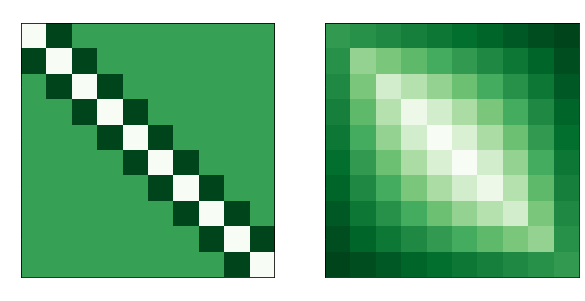

In [1]:
#| label: fig-prec_vs_cov
#| fig-cap: A sparse precision matrix will generally invert to a dense covariance matrix.


import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = '#0F2537'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Build precision and covariance
prec_mat = 2*sp.eye(10)
prec_mat.setdiag(-1,k=-1)
prec_mat.setdiag(-1,k=1)
prec_mat = prec_mat.toarray()
cov_mat = np.linalg.inv(prec_mat)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(prec_mat, cmap='Greens_r')
axs[0].set_title("Precision")
axs[1].imshow(cov_mat, cmap='Greens_r')
axs[1].set_title("Covariance")

plt.show()


The unnormalized density function for the GMRF is given as
$$
\pi(x) \propto \exp\left[ - \frac{1}{2} \left( x - \mu \right)^T Q \left( x - \mu \right) \right].
$$

# 1. Sampling a 1D GMRF


The GMRF we will consider is that with $\mu = 0$ and precision $Q = D^T D$, where
$$
D = \left(\begin{array}{ccccc} 
1  &    &          &          &   \\
-1 & 1  &          &          &   \\
   & -1 & 1        &          &   \\
   &    & \ddots & \ddots &   \\
   &    &          & -1       & 1
\end{array}\right)
$$ 
is an $N \times N$ matrix. Intuitively, this precision corresponds to a Gaussian random-walk on the line whose increments and initial value have distribution $\Delta x_i, x_0 \sim \mathcal{N}(0,1)$. One way to sample this GMRF is to use the "covariance method", which is to compute the Cholesky factorization $\Sigma = L L^T$ and then get a sample via 
$$
x = \mu + L z
$$ 
where $z \sim \mathcal{N}(0, I)$. Let's try this with $N = 100$ points.



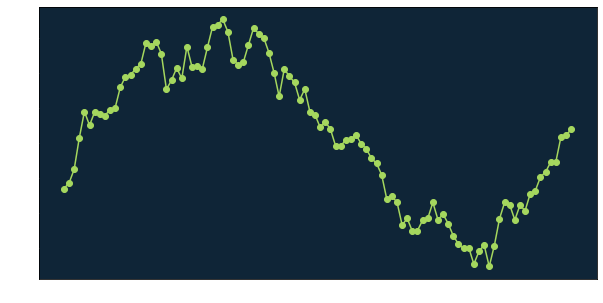

In [2]:
#| label: fig-random_walk_draw_cov_method
#| fig-cap: A single draw from a 1D GMRF, using the covariance method.

N = 100

# Build D matrix
d_mat = sp.eye(N)
d_mat.setdiag(-1, k=-1)
d_mat = sp.csr_matrix(d_mat)

# Build precision and covariance
prec_mat = d_mat.T @ d_mat
prec_mat = prec_mat.toarray()
cov_mat = np.linalg.inv(prec_mat)

# Get Cholesky factor of covariance
chol_fac = np.linalg.cholesky(cov_mat)

# Compute sample
np.random.seed(0)
z = np.random.normal(size=N)
sample_cov_method = chol_fac @ z

fig, axs = plt.subplots(figsize=(10,5))
axs.plot(sample_cov_method, "o-", color="#A5D75E")
#axs.set_title("A single draw from the random walk on the line")
plt.show()

Easy enough. However, a central concern when working with GMRFs is how well the method scales with the dimension $N$. Now let's do a naive experiment where we time how long it takes to compute a single sample as we increase $N$.

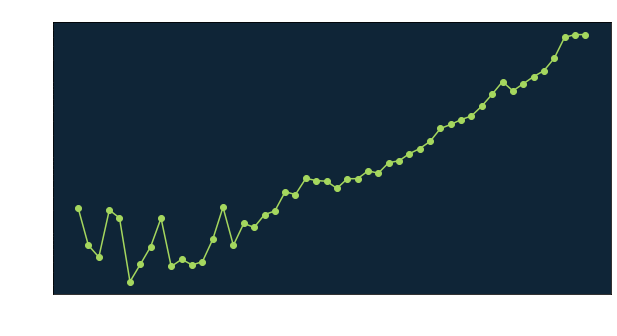

In [14]:
#| label: fig-random_walk_increasing_n_cov_method
#| fig-cap: Time to generate a single sample vs. number of points N, using the covariance method.

import time
from sklearn import datasets, linear_model

ns = np.logspace(2.5, 4, num=50)
ns = np.rint(ns).astype(np.int32)


def draw_single_sample_cov_method(n):
    """Draws a single sample from the RW model of size n,
    using the covariance method.
    """
    # Build D matrix
    d_mat = sp.eye(n)
    d_mat.setdiag(-1,k=-1)

    # Build precision and covariance
    prec_mat = d_mat.T @ d_mat
    prec_mat = prec_mat.toarray()
    cov_mat = np.linalg.inv(prec_mat)

    # Draw a sample
    np.random.seed(0)
    chol_fac = np.linalg.cholesky(cov_mat)
    z = np.random.normal(size=n)
    sample = chol_fac @ z
    
    return None

times = []
for n in ns:
    start = time.time()
    draw_single_sample_cov_method(n)
    end = time.time()
    elapsed = end - start
    times.append(elapsed)

regr = linear_model.LinearRegression()
regr.fit(np.log(ns)[:, None], np.log(times)[:, None])
slope = regr.coef_[0][0]

fig, axs = plt.subplots(figsize=(10,5))
axs.loglog(ns, times, "o-", color="#A5D75E")
axs.set_xlabel("N")
axs.set_ylabel("Time (milliseconds)")
axs.set_title(f"Slope = {slope:.1f}")
plt.show()

Generating a sample appears to cost $\mathcal{O}(N^\alpha)$ with $\alpha \approx 2$. The bottleneck in this method comes from the matrix inverse and Cholesky factorizations, which since the covariance is dense we should each expect to cost $\mathcal{O}(N^3)$ -- for whatever reason it seems we manage to do better than this though. 

We can do better than this by instead using the "precision method" that takes advantage of the sparsity of $Q$. Inserting the Cholesky factorization $Q = L L ^T$ into the previous covariance method, the precision method is to compute a sample via
$$
x = \mu + L^{-T} z
$$
with $z \sim \mathcal{N}(0,I)$. However, it will be important *how* we compute the Cholesky factorization. If we just use [`np.linalg.cholesky`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html) which handles dense matrices, we shouldn't expect to do any better. A nice property of sparse matrices is that if a matrix has a lower bandwidth of $p$, then its lower Cholesky factor $L$ also has bandwidth $p$. There are specific algorithms that have been designed to take advantage of this fact, such as those implemented in [`sksparse.cholmod`](https://scikit-sparse.readthedocs.io/en/latest/cholmod.html) which we will use.

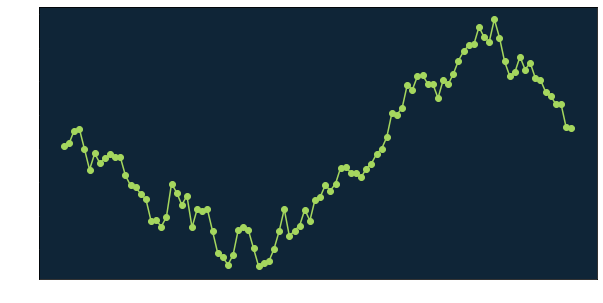

In [3]:
#| label: fig-random_walk_draw_prec_method
#| fig-cap: A single draw from a 1D GMRF, using the precision method.

from sksparse.cholmod import cholesky

N = 100

# Build D matrix
d_mat = sp.eye(N)
d_mat.setdiag(-1, k=-1)
d_mat = sp.csr_matrix(d_mat)

# Build precision
prec_mat = d_mat.T @ d_mat
prec_mat = sp.csc_matrix(prec_mat)

# Compute (sparse) cholesky factorization
# The natural ordering method doesn't permute the nodes (our precision is already sparse)
factor = cholesky(prec_mat, ordering_method='natural')

# Solve L^T x = z
np.random.seed(0)
z = np.random.normal(size=N)
sample_prec_method = factor.solve_Lt(z, use_LDLt_decomposition=False)

fig, axs = plt.subplots(figsize=(10,5))
axs.plot(sample_prec_method, "o-", color="#A5D75E")
#axs.set_title("A single draw from the random walk on the line")
plt.show()

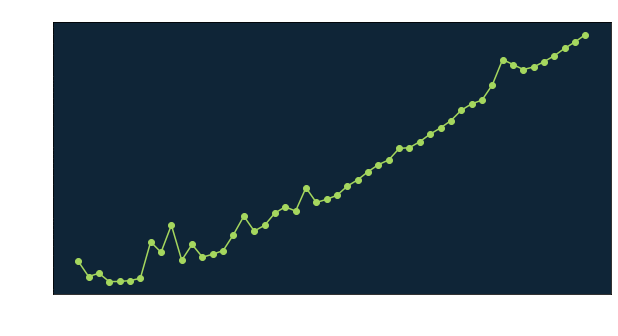

In [13]:
#| label: fig-random_walk_increasing_n_prec_method
#| fig-cap: Time to generate a single sample vs. number of points N, using the precision method.

import time
from sklearn import datasets, linear_model

ns = np.logspace(2.5, 7, num=50)
ns = np.rint(ns).astype(np.int32)


def draw_single_sample_prec_method(n):
    """Draws a single sample from the RW model of size n,
    using the covariance method.
    """
    d_mat = sp.eye(n)
    d_mat.setdiag(-1, k=-1)
    d_mat = sp.csr_matrix(d_mat)

    prec_mat = d_mat.T @ d_mat
    prec_mat = sp.csc_matrix(prec_mat)

    factor = cholesky(prec_mat, ordering_method='natural')

    np.random.seed(0)
    z = np.random.normal(size=n)
    sample = factor.solve_Lt(z, use_LDLt_decomposition=False)
    
    return None

times = []
for n in ns:
    start = time.time()
    draw_single_sample_prec_method(n)
    end = time.time()
    elapsed = end - start
    times.append(elapsed)

regr = linear_model.LinearRegression()
regr.fit(np.log(ns)[:, None], np.log(times)[:, None])
slope = regr.coef_[0][0]

fig, axs = plt.subplots(figsize=(10,5))
axs.loglog(ns, times, "o-", color="#A5D75E")
axs.set_xlabel("N")
axs.set_ylabel("Time (milliseconds)")
axs.set_title(f"Slope = {slope:.1f}")
plt.show()

Note that the precision method is significantly faster and has cost about $\mathcal{O}(N)$, as it leverages a sparse Cholesky factorization and a sparse linear system solver. For the rest of this post, we will use the precision method for drawing samples.

# Hierarchical representation of the Cauchy distribution

In order to sample from a CMRF, we will use a scale mixture of normal representation for the Cauchy distribution^[See Chapter 4 of [@Rue2005], also [here](https://betanalpha.github.io/assets/case_studies/fitting_the_cauchy.html#3_first_alternative_implementation)]. Suppose we wish to sample
$$
x \sim \text{Cauchy}(1).
$$
where $s = 1$ is the scale parameter of the Cauchy distribution. We can achieve this using the hierarchical representation
$$
\begin{align*}
\lambda &\sim \text{Gamma}(\nu/2,\nu/2) \\
x \, | \, \lambda &\sim \mathcal{N}(0, \lambda^{-1})
\end{align*}
$$
with the choice $\nu=1$. For general $\nu$, this gives us $x \sim \text{Student-}t_\nu$ for which the Cauchy distribution is a special case. With this sampling scheme, we have that the marginal density for $x$,
$$
\pi(x) = \int \pi(x \, | \lambda) \, \pi(\lambda) \, d\lambda,
$$
is the density for a $\text{Cauchy}(1)$-distributed random variable. If we want to control the scale parameter of the Cauchy distribution, we can modify this as 
\begin{align*}
\lambda &\sim \text{Gamma}(1/2,s^2/2) \\
x \, | \, \lambda &\sim \mathcal{N}(0, \lambda^{-1})
\end{align*}



<!-- where $s$ is the scale paramter of the Cauchy distribution. -->


<!-- $$
x \sim \text{Cauchy}(s)
$$
by instead sampling
$$
\begin{align*}
\lambda &\sim \text{Gamma}(a,b), \\
x &\sim \mathcal{N}(0, \lambda^{-1}).
\end{align*}
$$
In -->

# 2. Sampling a 1D CMRF

Now let's put this hierarchical representation to work. To obtain a CMRF from a GMRF, we will sample
\begin{align*}
\lambda_1, \ldots, \lambda_N &\sim \text{Gamma}(1/2, s^2/2) \\
H &= \text{diag}(\lambda_1, \ldots, \lambda_N) \\
x \, | \, H &\sim \mathcal{N}\left(\mu, Q^{-1} = \left( D^T H D \right)^{-1} \right)
\end{align*}
where $H$ is a diagonal matrix collecting the hyper-parameters and $D$ is the same differencing matrix as before. The marginal density for $x$,
\begin{equation*}
\pi(x) = \int \pi(x | \lambda_1, \ldots, \lambda_N) \pi(\lambda_1, \ldots, \lambda_N) \, d\lambda_1 \, \ldots \, d\lambda_N
\end{equation*}
is the density function for a CMRF.

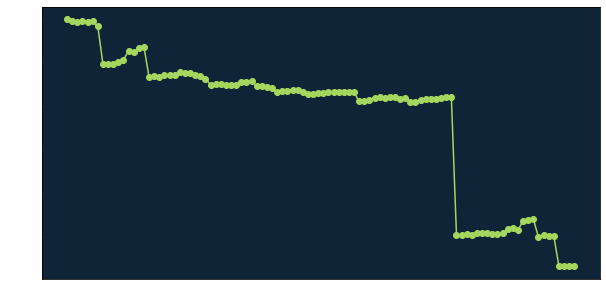

In [4]:
#| label: fig-cauchy_random_walk_draw_prec_method
#| fig-cap: A single draw from a 1D CMRF.

from sksparse.cholmod import cholesky
from scipy.stats import gamma

N = 100
s = 1

# Build D matrix
d_mat = sp.eye(N)
d_mat.setdiag(-1, k=-1)
d_mat = sp.csr_matrix(d_mat)

# Sample the hyperparameters
np.random.seed(0)
h_mat = gamma.rvs(1/2, scale=(s**2)/2, size=N)
h_mat = sp.diags(h_mat)

# Build precision
prec_mat = d_mat.T @ h_mat @ d_mat
prec_mat = sp.csc_matrix(prec_mat)

# Compute (sparse) cholesky factorization
# The natural ordering method doesn't permute the nodes (our precision is already sparse)
factor = cholesky(prec_mat, ordering_method='natural')

# Solve L^T x = z
z = np.random.normal(size=N)
sample_prec_method = factor.solve_Lt(z, use_LDLt_decomposition=False)

fig, axs = plt.subplots(figsize=(10,5))
axs.plot(sample_prec_method, "o-", color="#A5D75E")
#axs.set_title("A single draw from the random walk on the line")
plt.show()

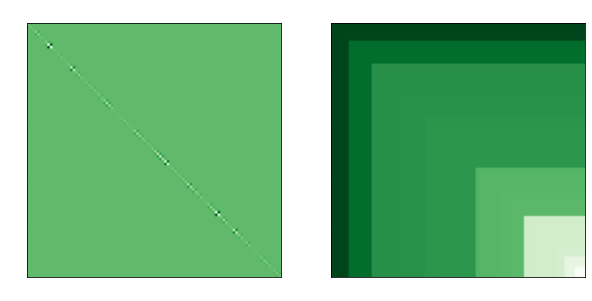

In [5]:
#| label: fig-cauchy_random_walk_prec_cov_mats
#| fig-cap: Precision and covariance matrices corresponding to the sample in @fig-cauchy_random_walk_draw_prec_method

N = 100
s = 1

d_mat = sp.eye(N)
d_mat.setdiag(-1,k=-1)

np.random.seed(0)
h_mat = gamma.rvs(1/2, scale=(s**2)/2, size=N)
h_mat = sp.diags(h_mat)

prec_mat = d_mat.T @  h_mat @ d_mat
prec_mat = prec_mat.toarray()
cov_mat = np.linalg.inv(prec_mat)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(prec_mat, cmap='Greens_r')
axs[0].set_title("Precision")
axs[1].imshow(cov_mat, cmap='Greens_r')
axs[1].set_title("Covariance")

plt.show()


Compared to our sample from a GMRF from earlier, the sample from the CMRF has infrequent massive jumps. This makes sense, since our CMRF is modeling increments as being Cauchy-distributed and the Cauchy distribution has infinite variance. Let's look at some more samples from each.

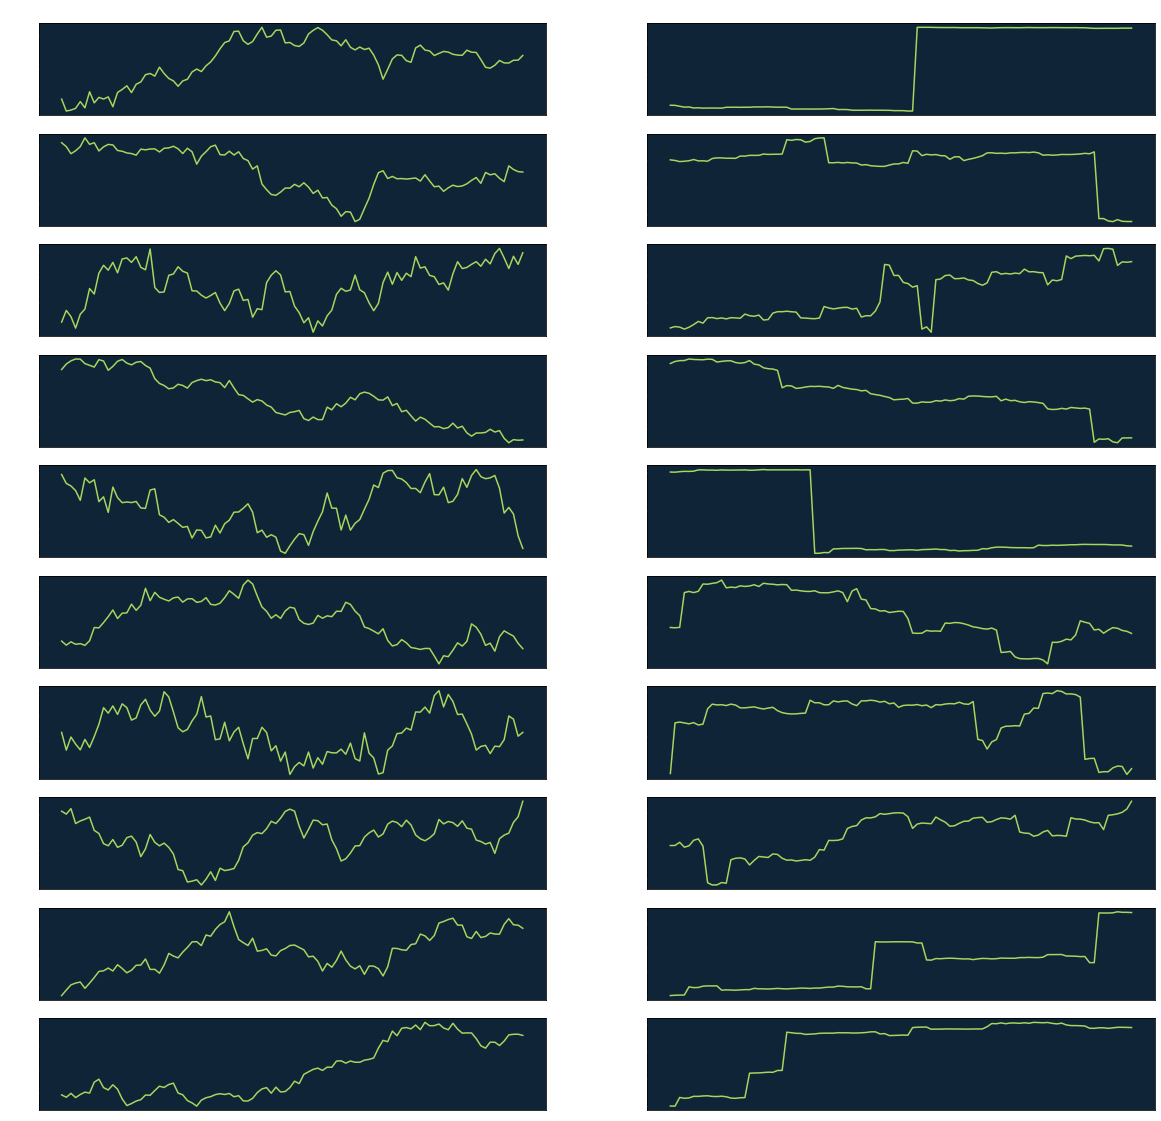

In [6]:
#| label: fig-gmrf_cmrf_comparison
#| fig-cap: 10 samples each from our GMRF/CMRF. Each row uses the same draw $z \sim \mathcal{N}(0,I)$.

from sksparse.cholmod import cholesky

N = 100
n_samples = 10
np.random.seed(1)

# Arrays for storing samples
gmrf_samples = np.zeros((n_samples, N))
cmrf_samples = np.zeros((n_samples, N))

# Build D matrix
d_mat = sp.eye(N)
d_mat.setdiag(-1, k=-1)
d_mat = sp.csr_matrix(d_mat)

fig, axs = plt.subplots(n_samples, 2, figsize=(20,20))

for j in range(n_samples):

    # Draw normal increments
    z = np.random.normal(size=N)

    # Get GMRF sample
    prec_mat = d_mat.T @ d_mat
    prec_mat = sp.csc_matrix(prec_mat)
    factor = cholesky(prec_mat, ordering_method='natural')
    gmrf_samples[j,:] = factor.solve_Lt(z, use_LDLt_decomposition=False)

    # Get CMRF sample
    h_mat = gamma.rvs(1/2, scale=(s**2)/2, size=N)
    h_mat = sp.diags(h_mat)
    prec_mat = d_mat.T @  h_mat @ d_mat
    prec_mat = sp.csc_matrix(prec_mat)
    factor = cholesky(prec_mat, ordering_method='natural')
    cmrf_samples[j,:] = factor.solve_Lt(z, use_LDLt_decomposition=False)

    # Plot
    axs[j,0].plot(gmrf_samples[j,:], color="#A5D75E")
    axs[j,1].plot(cmrf_samples[j,:], color="#A5D75E")
    axs[j,0].set_xticks([])
    axs[j,1].set_xticks([])

axs[0,0].set_title("GMRF Samples")
axs[0,1].set_title("CMRF Samples")

plt.show()

# 3. Sampling a 2D GMRF/CMRF

Making the jump to a 2D GMRF is not too difficult. Whereas in our earlier examples for a 1D random walk with $N$ points our precision matrix $Q$ was $N \times N$, in 2D on an $M \times N$ grid our precision matrix will need to be an $M^2 \times N^2$ matrix. The 2D GMRF we will consider is an "anisotropic difference prior" that is an extension of our 1D GMRF from earlier, with $\mu = 0$ and precision
\begin{equation*}
Q = F^T F.
\end{equation*}
Here
\begin{equation*}
F = \begin{bmatrix}
           D_1 \\
           D_2
         \end{bmatrix},
\end{equation*}
where the $D_{1/2}$ are given by
\begin{align*}
D_1 &= I_N \otimes D, \\
D_2 &= D \otimes I_M,
\end{align*}
and $D$ is the same matrix from our 1D example.


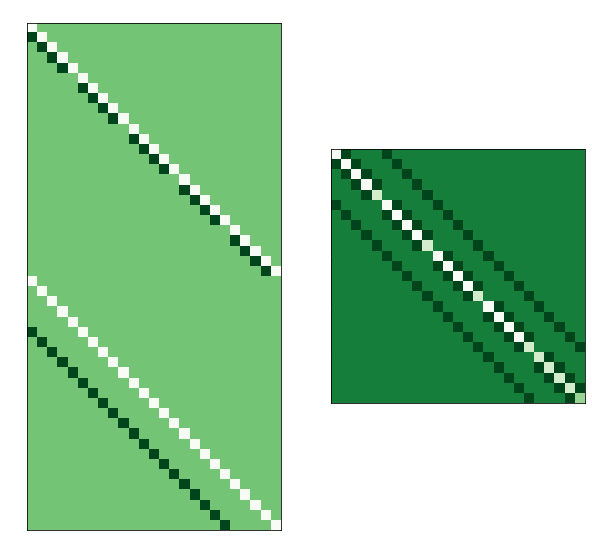

In [12]:
#| label: fig-2d_diff_mat
#| fig-cap: The matrices $F$ and $Q$ for a $20 \times 20$ lattice.

M, N = 5, 5

# Build D matrices
d_mat_vert = sp.eye(M)
d_mat_vert.setdiag(-1,k=-1)
eye_horiz = sp.eye(N)
d_mat_one = sp.kron(eye_horiz, d_mat_vert)

d_mat_horiz = sp.eye(N)
d_mat_horiz.setdiag(-1,k=-1)
eye_vert = sp.eye(M)
d_mat_two = sp.kron(d_mat_horiz, eye_vert)

d_mat = sp.vstack([d_mat_one, d_mat_two])
prec_mat = d_mat.T @ d_mat

fig, axs = plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(d_mat.toarray(), cmap='Greens_r')
axs[0].set_title('F')
axs[1].imshow(prec_mat.toarray(), cmap='Greens_r')
axs[1].set_title('Q')

plt.show()

Now that we have our precision matrix, we can sample the GMRF just as we did in the 1D case.

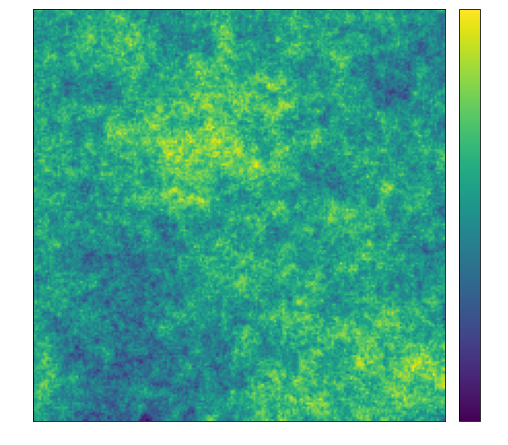

In [19]:
#| label: fig-2d_gmrf_sample
#| fig-cap: A sample of our GMRF on a $200 \times 200$ lattice.

M, N = 200, 200

# Build D matrices
d_mat_vert = sp.eye(M)
d_mat_vert.setdiag(-1,k=-1)
eye_horiz = sp.eye(N)
d_mat_one = sp.kron(eye_horiz, d_mat_vert)

d_mat_horiz = sp.eye(N)
d_mat_horiz.setdiag(-1,k=-1)
eye_vert = sp.eye(M)
d_mat_two = sp.kron(d_mat_horiz, eye_vert)

d_mat = sp.vstack([d_mat_one, d_mat_two])

# Build precision
prec_mat = d_mat.T @ d_mat
prec_mat = sp.csc_matrix(prec_mat)

# Get Cholesky factor
factor = cholesky(prec_mat, ordering_method='natural')

# Draw a sample
np.random.seed(0)
z = np.random.normal(size=(M,N)).flatten()
sample = factor.solve_Lt(z, use_LDLt_decomposition=False)
sample = sample.reshape((M,N))

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(8,8))
ax = plt.gca()
im = ax.imshow(sample)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)
plt.show()

Let's also make a "movie" for a sequence of samples.

In [77]:
from moviepy.editor import ImageSequenceClip

n_samples = 10
samples = np.zeros((n_samples, M, N))

# Draw samples
np.random.seed(0)
for j in range(n_samples):
    z = np.random.normal(size=(M,N)).flatten()
    samples[j,:,:] = factor.solve_Lt(z, use_LDLt_decomposition=False).reshape((M,N))

fps = int(0.1*n_samples)
min_val = np.amin(samples)
max_val = np.amax(samples)

samples -= min_val
samples /= max_val - min_val

colored_samples = np.zeros((n_samples, M, N, 4))
cmap = plt.get_cmap()
for j in range(n_samples):
    #print(cmap(samples[j,:,:]))
    colored_samples[j,:,:,:] = cmap(samples[j,:,:])

colored_samples *= 255

clip = ImageSequenceClip(list(colored_samples), fps=fps)
clip.write_gif('gmrf_samples.gif', fps=fps, verbose=False, logger=None)

<img src="gmrf_samples.gif" width="500" height="500" />

Now that we can sample from a 2D GMRF, it is straightforward to add in hyper-parameters that turn our GMRF into a CMRF. To do this, we sample
\begin{align*}
\lambda_1, \ldots, \lambda_{2N^2} &\sim \text{Gamma}(1/2, s^2/2) \\
H \, | \, \lambda_1, \ldots, \lambda_{2N^2} &= \text{diag}(\lambda_1, \ldots, \lambda_{2N^2}) \\
x \, | \, H &\sim \mathcal{N}\left(\mu, Q^{-1} = \left( F^T H F \right)^{-1} \right).
\end{align*}
Let's try sampling this.


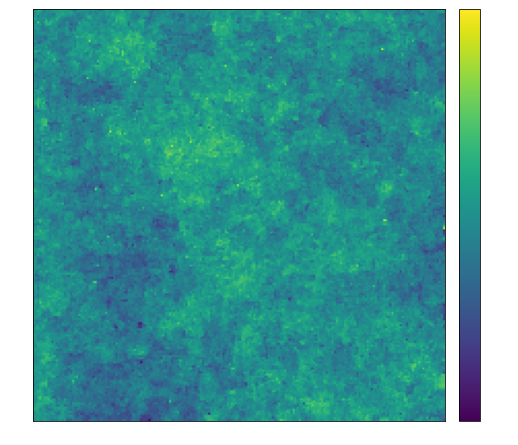

In [21]:
#| label: fig-2d_cmrf_sample
#| fig-cap: A sample of our CMRF on a $200 \times 200$ lattice.

from scipy.stats import gamma

M, N = 200, 200
s = 1.0

# Build D matrices
d_mat_vert = sp.eye(M)
d_mat_vert.setdiag(-1,k=-1)
eye_horiz = sp.eye(N)
d_mat_one = sp.kron(eye_horiz, d_mat_vert)

d_mat_horiz = sp.eye(N)
d_mat_horiz.setdiag(-1,k=-1)
eye_vert = sp.eye(M)
d_mat_two = sp.kron(d_mat_horiz, eye_vert)

d_mat = sp.vstack([d_mat_one, d_mat_two])

# Sample hyperparamters
h_mat = gamma.rvs(1/2, scale=1/((s**2)/2), size=2*M*N)
h_mat = sp.diags(h_mat)

# Build precision
prec_mat = d_mat.T @ h_mat @ d_mat
prec_mat = sp.csc_matrix(prec_mat)

# Get Cholesky factor
factor = cholesky(prec_mat, ordering_method='natural')

# Draw a sample
np.random.seed(0)
z = np.random.normal(size=(M,N)).flatten()
sample = factor.solve_Lt(z, use_LDLt_decomposition=False)
sample = sample.reshape((M,N))

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize=(8,8))
ax = plt.gca()
im = ax.imshow(sample)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)
plt.show()

Let's make another movie while we're at it.

In [23]:
from moviepy.editor import ImageSequenceClip

n_samples = 10
samples = np.zeros((n_samples, M, N))

# Draw samples
np.random.seed(0)
for j in range(n_samples):

    # Sample hyperparamters
    h_mat = gamma.rvs(1/2, scale=1/((s**2)/2), size=2*M*N)
    h_mat = sp.diags(h_mat)

    # Build precision
    prec_mat = d_mat.T @ h_mat @ d_mat
    prec_mat = sp.csc_matrix(prec_mat)

    # Get Cholesky factor
    factor = cholesky(prec_mat, ordering_method='natural')

    z = np.random.normal(size=(M,N)).flatten()
    samples[j,:,:] = factor.solve_Lt(z, use_LDLt_decomposition=False).reshape((M,N))

fps = int(0.1*n_samples)
min_val = np.amin(samples)
max_val = np.amax(samples)

samples -= min_val
samples /= max_val - min_val

colored_samples = np.zeros((n_samples, M, N, 4))
cmap = plt.get_cmap()
for j in range(n_samples):
    #print(cmap(samples[j,:,:]))
    colored_samples[j,:,:,:] = cmap(samples[j,:,:])

colored_samples *= 255

clip = ImageSequenceClip(list(colored_samples), fps=fps)
clip.write_gif('cmrf_samples.gif', fps=fps, verbose=False, logger=None)

<img src="cmrf_samples.gif" width="500" height="500" />

So we have achieved our goal. In a future post, we will put this to work as a prior in an inverse problem.

# Bonus: some extra MRFs

While we used a scale mixture of normal representation for the Cauchy distribution, we can also obtain other distributions as scale mixtures of normals. For example, we can simulate a MRF where the increments follow a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution)
by sampling
\begin{align*}
\beta_1, \ldots, \beta_{2N^2} &\sim \text{Exponential} \\
\lambda_i \, | \, \beta_i &= \frac{1}{2\beta_i} \\
H \, | \, \lambda_1, \ldots, \lambda_{2N^2} &= \text{diag}(\lambda_1, \ldots, \lambda_{2N^2}) \\
x \, | \, H &\sim \mathcal{N}\left(\mu, Q^{-1} = \left( F^T H F \right)^{-1} \right).
\end{align*}

Similarly, we can get a MRF increments with Horshoe-distributed [@Carvalho2009] increments by sampling
\begin{align*}
\beta_1, \ldots, \beta_{2N^2} &\sim \text{C}^+(0, 1) \\
\lambda_i \, | \, \beta_i, \tau &= \frac{1}{\beta_i^2 \tau^2} \\
H \, | \, \lambda_1, \ldots, \lambda_{2N^2} &= \text{diag}(\lambda_1, \ldots, \lambda_{2N^2}) \\
x \, | \, H &\sim \mathcal{N}\left(\mu, Q^{-1} = \left( F^T H F \right)^{-1} \right)
\end{align*}
where $\tau$ is some fixed hyper-hyper-parameter and $C^+$ denotes the [half-Cauchy distribution](https://distribution-explorer.github.io/continuous/halfcauchy.html). Below are some movies of samples from a Laplace MRF and Horshoe MRF, respectively.

In [8]:
from moviepy.editor import ImageSequenceClip

n_samples = 10
samples = np.zeros((n_samples, M, N))

# Draw samples
np.random.seed(0)
for j in range(n_samples):

    # Sample hyperparamters
    h_mat = (1/(2*np.random.exponential(size=2*M*N)))
    h_mat = sp.diags(h_mat)

    # Build precision
    prec_mat = d_mat.T @ h_mat @ d_mat
    prec_mat = sp.csc_matrix(prec_mat)

    # Get Cholesky factor
    factor = cholesky(prec_mat, ordering_method='natural')

    z = np.random.normal(size=(M,N)).flatten()
    samples[j,:,:] = factor.solve_Lt(z, use_LDLt_decomposition=False).reshape((M,N))

fps = int(0.1*n_samples)
min_val = np.amin(samples)
max_val = np.amax(samples)

samples -= min_val
samples /= max_val - min_val

colored_samples = np.zeros((n_samples, M, N, 4))
cmap = plt.get_cmap()
for j in range(n_samples):
    #print(cmap(samples[j,:,:]))
    colored_samples[j,:,:,:] = cmap(samples[j,:,:])

colored_samples *= 255

clip = ImageSequenceClip(list(colored_samples), fps=fps)
clip.write_gif('lmrf_samples.gif', fps=fps, verbose=False, logger=None)


from scipy.stats import halfcauchy

tau = 1.0

n_samples = 10
samples = np.zeros((n_samples, M, N))

# Draw samples
np.random.seed(0)
for j in range(n_samples):

    # Sample hyperparamters
    h_mat = (  1/(  (tau*halfcauchy.rvs(size=2*M*N))**2)  )
    h_mat = sp.diags(h_mat)

    # Build precision
    prec_mat = d_mat.T @ h_mat @ d_mat
    prec_mat = sp.csc_matrix(prec_mat)

    # Get Cholesky factor
    factor = cholesky(prec_mat, ordering_method='natural')

    z = np.random.normal(size=(M,N)).flatten()
    samples[j,:,:] = factor.solve_Lt(z, use_LDLt_decomposition=False).reshape((M,N))

fps = int(0.1*n_samples)
min_val = np.amin(samples)
max_val = np.amax(samples)

samples -= min_val
samples /= max_val - min_val

colored_samples = np.zeros((n_samples, M, N, 4))
cmap = plt.get_cmap()
for j in range(n_samples):
    #print(cmap(samples[j,:,:]))
    colored_samples[j,:,:,:] = cmap(samples[j,:,:])

colored_samples *= 255

clip = ImageSequenceClip(list(colored_samples), fps=fps)
clip.write_gif('hmrf_samples.gif', fps=fps, verbose=False, logger=None)

::: {layout-ncol=2}
<img src="lmrf_samples.gif" width="400" height="400" />

<img src="hmrf_samples.gif" width="400" height="400" />
:::